<a href="https://colab.research.google.com/github/Masum06/Automated-Ataxia-Gait/blob/main/Signal_analysis_and_classification_Ataxia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install antropy

In [ ]:
import numpy as np
import copy
from scipy.stats.stats import pearsonr
import antropy as ent
import pandas as pd
import json
import pickle
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate

# Feature Calculation

In [ ]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

In [ ]:
infile = open('keypoints_dict_c2.pkl','rb')
keypoints_dict = pickle.load(infile)
infile.close()

In [ ]:
df = pd.read_csv('labeling_c2.csv')
df.head()

In [ ]:
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data

patient_height_dict = getJsonData('patient_height_dict_c2.json')

## Computation

In [ ]:
reduction_score = {}
stance_dict = {}
for key in patient_height_dict:
    frame_list = patient_height_dict[key]
    last_frame = frame_list[0]
    sum_reduction = 0
    stance_score = 0
    for h in frame_list:
        reduction = last_frame - h
        stance_score += reduction<=0
        last_frame = h
        sum_reduction += reduction
    reduction_score[key] = sum_reduction/frame_list[0]
    stance_dict[key] = stance_score/len(frame_list)

In [ ]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
  r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
  The Savitzky-Golay filter removes high frequency noise from data.
  It has the advantage of preserving the original shape and
  features of the signal better than other types of filtering
  approaches, such as moving averages techniques.
  https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
  Parameters
  ----------
  y : array_like, shape (N,)
      the values of the time history of the signal.
  window_size : int
      the length of the window. Must be an odd integer number.
  order : int
      the order of the polynomial used in the filtering.
      Must be less then `window_size` - 1.
  deriv: int
      the order of the derivative to compute (default = 0 means only smoothing)
  Returns
  -------
  ys : ndarray, shape (N)
      the smoothed signal (or it's n-th derivative).
  Notes
  -----
  The Savitzky-Golay is a type of low-pass filter, particularly
  suited for smoothing noisy data. The main idea behind this
  approach is to make for each point a least-square fit with a
  polynomial of high order over a odd-sized window centered at
  the point.
  Examples
  --------
  t = np.linspace(-4, 4, 500)
  y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
  ysg = savitzky_golay(y, window_size=31, order=4)
  import matplotlib.pyplot as plt
  plt.plot(t, y, label='Noisy signal')
  plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
  plt.plot(t, ysg, 'r', label='Filtered signal')
  plt.legend()
  plt.show()
  References
  ----------
  .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
    Data by Simplified Least Squares Procedures. Analytical
    Chemistry, 1964, 36 (8), pp 1627-1639.
  .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
    W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
    Cambridge University Press ISBN-13: 9780521880688
  """
  import numpy as np
  from math import factorial

  try:
      window_size = np.abs(np.int(window_size))
      order = np.abs(np.int(order))
  except (ValueError, msg):
      raise ValueError("window_size and order have to be of type int")
  if window_size % 2 != 1 or window_size < 1:
      raise TypeError("window_size size must be a positive odd number")
  if window_size < order + 2:
      raise TypeError("window_size is too small for the polynomials order")
      
  order_range = range(order+1)
  half_window = (window_size -1) // 2
  # precompute coefficients
  b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
  m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
  # pad the signal at the extremes with
  # values taken from the signal itself
  firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
  lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
  y = np.concatenate((firstvals, y, lastvals))
  return np.convolve( m[::-1], y, mode='valid')

In [ ]:
from numpy import dot
from numpy.linalg import norm

all_label = []
height_reduction = []
stance_ratio = []
all_vid_names = []

feature_dict_template = {
  'feet_dist' : [],
  'feet_angle' : [],
  'right_x' : [],
  'right_y' : [],
  'left_x' : [],
  'left_y' : [],
  'left_knee_bent': [],
  'right_knee_bent': [],
  'imbalance' : [],
  'tilt': [],
  'nose_x': [],
  'nose_y': []
}

feature_list = ['entropy', 'mean', 'std', 'max', 'min', 'range'] #, 'fourier'

feature_dict = {}
for feature in feature_list:
  feature_dict[feature] = copy.deepcopy(feature_dict_template)


for (id, score) in zip(df['ID'], df['Score']):

  if id[-4:].lower() != '.mp4':
    print(id, "extension added")
    vid_name = id+'.mp4'
  else:
    vid_name = id

  if vid_name not in keypoints_dict:
    print(vid_name, "passing")
    continue

  all_label.append(score) 
  all_vid_names.append(vid_name)
  # all_label.append((score>0)*1)

  height_reduction.append(reduction_score[vid_name])
  stance_ratio.append(stance_dict[vid_name])

  accumulation_dict = copy.deepcopy(feature_dict_template)

  for pose in keypoints_dict[vid_name]:
    if len(pose[0])==17:
      l_ankle = pose[0][KEYPOINT_DICT['left_ankle']]
      r_ankle = pose[0][KEYPOINT_DICT['right_ankle']]

      l1 = pose[0][KEYPOINT_DICT['left_hip']] - pose[0][KEYPOINT_DICT['left_knee']]
      l2 = pose[0][KEYPOINT_DICT['left_ankle']] - pose[0][KEYPOINT_DICT['left_knee']]
      r1 = pose[0][KEYPOINT_DICT['right_hip']] - pose[0][KEYPOINT_DICT['right_knee']]
      r2 = pose[0][KEYPOINT_DICT['right_ankle']] - pose[0][KEYPOINT_DICT['right_knee']]
      l_knee = dot(l1,l2)/(norm(l1)*norm(l2))
      r_knee = dot(l1,l2)/(norm(r1)*norm(r2))

      shoulder_center = pose[0][KEYPOINT_DICT['left_shoulder']]/2 + pose[0][KEYPOINT_DICT['right_shoulder']]/2
      hip_center = pose[0][KEYPOINT_DICT['left_hip']]/2 + pose[0][KEYPOINT_DICT['right_hip']]/2
      imbalance = shoulder_center[0] - hip_center[0]
      tilt = (pose[0][KEYPOINT_DICT['right_shoulder']] - pose[0][KEYPOINT_DICT['left_shoulder']])
      nose = pose[0][KEYPOINT_DICT['nose']]

      accumulation_dict['right_x'].append(r_ankle[0])
      accumulation_dict['right_y'].append(r_ankle[1])
      accumulation_dict['left_x'].append(l_ankle[0])
      accumulation_dict['left_y'].append(l_ankle[1])
      
      
      dist = np.linalg.norm(l_ankle-r_ankle)
      angle = np.arctan((l_ankle-r_ankle)[1]/(l_ankle-r_ankle)[0])
      
      accumulation_dict['feet_dist'].append(dist)
      accumulation_dict['feet_angle'].append(angle)
      accumulation_dict['left_knee_bent'].append(l_knee)
      accumulation_dict['right_knee_bent'].append(r_knee)
      accumulation_dict['imbalance'].append(imbalance)
      # accumulation_dict['tilt_x'].append(tilt[0])
      accumulation_dict['tilt'].append(np.arctan(tilt[1]/tilt[0]))
      accumulation_dict['nose_x'].append(nose[0])
      accumulation_dict['nose_y'].append(nose[1])

  for key in accumulation_dict:
    accumulation_dict[key] = savitzky_golay(accumulation_dict[key], 21, 3)

  ## Extract features from each sequence and make a single number feature
  for key in feature_dict[list(feature_dict.keys())[0]]:
    feature_dict['entropy'][key].append(np.round(ent.spectral_entropy(accumulation_dict[key], sf=1, method='fft'), 3))
    feature_dict['mean'][key].append(accumulation_dict[key].mean())
    feature_dict['std'][key].append(accumulation_dict[key].std())
    feature_dict['max'][key].append(accumulation_dict[key].max())
    feature_dict['min'][key].append(accumulation_dict[key].min())
    feature_dict['range'][key].append(accumulation_dict[key].max() - accumulation_dict[key].min()) 

In [ ]:
data = pd.DataFrame()

all_label = np.array(all_label)
height_reduction = np.array(height_reduction)
stance_ratio = np.array(stance_ratio)

for feature_type in feature_dict:
  for feature_name in feature_dict[feature_type]:
    col_name = feature_type+"_"+feature_name
    col = np.array(feature_dict[feature_type][feature_name])
    col[np.isnan(col)] = 0
    data[col_name] = col #np.round((col - col.mean())/col.std())

    # corr = pearsonr(all_label, col)
    # if corr[1] <= 0.05:
    #   print(col_name, corr, u'\u2713')
    #   # data[col_name] = np.round((col - col.mean())/col.std())
    # else:
    #   print(col_name, corr)

data['stance_ratio'] = stance_ratio 
data['height_reduction'] = height_reduction 
# data['label'] = all_label
data['label'] = all_label #1*(np.array(all_label)>0)
# data['ID'] = all_vid_names

In [ ]:
# data.to_csv('ataxia_data_c2.csv', index=False)

# Data Processing

In [ ]:
data = pd.read_csv('ataxia_data_c2.csv')

In [ ]:
data

In [ ]:
all_vid_names = data['ID']
data = data.drop(['ID'], axis=1)

In [ ]:
for key in list(data.keys())[:-2]: 
  data[key] = np.round((data[key] - data[key].mean())/data[key].std())

## Height reduction is exepmted from rounding
data['height_reduction'] = (data['height_reduction'] - data['height_reduction'].mean())/data['height_reduction'].std()

## Binarize Label
# data['label'] = 1*(data['label']>0)

## 4 Classes
labels = np.array(data['label'])
labels[labels>2] = 3
data['label'] = labels

In [ ]:
data

# Training Classifier

### Classifier with all features

In [ ]:
X = data.drop(['label'] , axis = 1)
Y = data['label']

# from sklearn.model_selection import train_test_split
# xtrain , xtest , ytrain , ytest = train_test_split(X,Y,test_size = 0.3)

In [ ]:
xtrain, xtest = X[16:], X[:16]
ytrain, ytest = Y[16:], Y[:16]

In [ ]:
model = tree.DecisionTreeClassifier()
model.fit(xtrain , ytrain)
model.score(xtest,ytest)

0.3125

In [ ]:
rf_scores = []
for i in range(15):
  model = RandomForestClassifier(n_estimators=100)
  model.fit(xtrain,ytrain)
  rf_scores.append(model.score(xtest , ytest))

np.mean(rf_scores)

0.6041666666666666

10 fold with all features

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate

aggregate_f1 = []
aggregate_acc = []
for i in range(20):
  model = RandomForestClassifier(n_estimators=100)
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  scores = cross_validate(model, X, Y, scoring=['f1_macro', 'accuracy'], cv=cv, n_jobs=-1)
  # aggregate_score.append(scores.mean())
  aggregate_f1.append(scores['test_f1_macro'].mean())
  aggregate_acc.append(scores['test_accuracy'].mean())

np.mean(aggregate_f1), np.mean(aggregate_acc)

(0.44662665438824745, 0.6042708333333333)

## Random Forest feature importance

In [ ]:
# First train a model with all data
model = RandomForestClassifier(n_estimators=100)
model.fit(X,Y)

RandomForestRegressor(max_depth=10, random_state=0)

In [ ]:
fi = model.feature_importances_
cols = np.array(data.columns[:-1])

In [ ]:
fiidx = fi.argsort()
sorted_fi = fi[fiidx[::-1]]
sorted_cols = cols[fiidx[::-1]]

In [ ]:
sorted_cols

array(['mean_feet_dist', 'height_reduction', 'max_feet_dist',
       'max_right_x', 'std_imbalance', 'min_left_x', 'range_imbalance',
       'range_nose_x', 'mean_nose_y', 'min_nose_x', 'entropy_nose_y',
       'std_tilt', 'std_left_x', 'range_feet_dist', 'range_left_x',
       'std_feet_dist', 'mean_tilt', 'mean_right_knee_bent',
       'entropy_tilt', 'entropy_right_knee_bent', 'entropy_feet_dist',
       'mean_feet_angle', 'mean_left_knee_bent', 'min_imbalance',
       'range_right_x', 'mean_left_y', 'std_nose_x', 'entropy_imbalance',
       'std_nose_y', 'min_right_knee_bent', 'min_feet_dist', 'min_nose_y',
       'mean_nose_x', 'range_feet_angle', 'stance_ratio',
       'mean_imbalance', 'min_tilt', 'std_feet_angle', 'entropy_right_y',
       'mean_right_x', 'min_feet_angle', 'min_left_y', 'max_left_y',
       'entropy_right_x', 'mean_right_y', 'entropy_nose_x', 'max_nose_y',
       'range_tilt', 'range_right_y', 'entropy_left_y', 'range_left_y',
       'std_right_knee_bent', 'ent

In [ ]:
rf_selected_cols = sorted_cols[:20]
rf_selected_cols

array(['mean_feet_dist', 'height_reduction', 'max_feet_dist',
       'max_right_x', 'std_imbalance', 'min_left_x', 'range_imbalance',
       'range_nose_x', 'mean_nose_y', 'min_nose_x', 'entropy_nose_y',
       'std_tilt', 'std_left_x', 'range_feet_dist', 'range_left_x',
       'std_feet_dist', 'mean_tilt', 'mean_right_knee_bent',
       'entropy_tilt', 'entropy_right_knee_bent'], dtype=object)

10 fold cross validation with rf selected features

In [ ]:
# Classification feature selection

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

inc_scores = []
for i in range(1,len(sorted_cols)):
  model = RandomForestClassifier(n_estimators=100)
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  scores = cross_val_score(model, X[sorted_cols[:i]], Y, scoring='f1_macro', cv=cv, n_jobs=-1)
  print(i, scores.mean())
  inc_scores.append(scores.mean())

In [ ]:
## Regression feature selection

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

inc_scores = []
for i in range(1,len(sorted_cols)):
  model = RandomForestRegressor(n_estimators=100)
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  scores = cross_val_score(model, X[sorted_cols[:i]], Y, scoring='r2', cv=cv, n_jobs=-1)
  print(i, scores.mean())
  inc_scores.append(scores.mean())

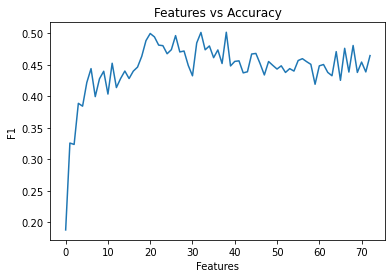

In [ ]:
# importing the required module
import matplotlib.pyplot as plt

plt.plot(inc_scores)
plt.xlabel('Features')
# naming the y axis
plt.ylabel('F1')
# giving a title to my graph
plt.title('Features vs Accuracy')
# function to show the plot
plt.show()

Cross validation with top features

In [ ]:
aggregate_f1 = []
aggregate_acc = []
for i in range(20):
  model = RandomForestClassifier(n_estimators=100)
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  scores = cross_validate(model, X[sorted_cols[:21]], Y, scoring=['f1_macro', 'accuracy'], cv=cv, n_jobs=-1)
  # aggregate_score.append(scores.mean())
  aggregate_f1.append(scores['test_f1_macro'].mean())
  aggregate_acc.append(scores['test_accuracy'].mean())

np.mean(aggregate_f1), np.mean(aggregate_acc)

(0.48102190067486117, 0.6298125000000001)

## Recirsive Feature Elimination with Cross Validation (RFECV)

https://github.com/WSU-SEAL/CRA-usefulness-model/blob/main/Usefulness%20Pipeline.ipynb

In [ ]:
X = data.drop(['label'] , axis = 1)
Y = data['label']

In [ ]:
rf = RandomForestClassifier(n_estimators=100 )

In [ ]:
rf = RandomForestRegressor()

In [ ]:
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(10), scoring='r2') 
# Regression: r2, Classification: f1_macro
rfecv.fit(X, Y)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestRegressor(), scoring='r2')

The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.


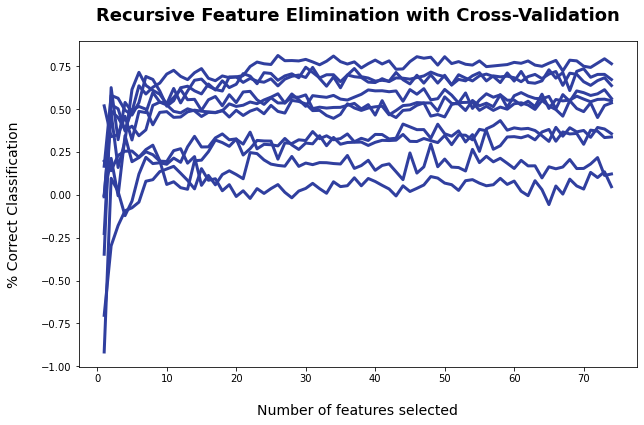

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [ ]:
## Number of features selected
rfecv.n_features_

73

In [ ]:
rfacv_selected_cols = []
for i in range(len(cols)):
    # print(cols[i],"\t",rfecv.support_[i],"\t",rfecv.ranking_[i])
    if rfecv.support_[i]==True:
        rfacv_selected_cols += [cols[i]]
rfacv_selected_cols

In [ ]:
len(rfacv_selected_cols)

73

In [ ]:
X = data[rfacv_selected_cols]
xtrain, xtest = X[16:], X[:16]

In [ ]:
rfacv_selected_cols = ['mean_feet_dist', 'std_left_x', 'std_imbalance', 'std_nose_y', 'max_feet_dist', 'max_right_x', 'min_left_x', 'min_imbalance', 'range_left_x', 'range_imbalance', 'range_nose_x', 'height_reduction']

**Binary selected columns:** 
['mean_feet_dist',
 'std_left_x',
 'std_imbalance',
 'std_nose_y',
 'max_feet_dist',
 'max_right_x',
 'min_left_x',
 'min_imbalance',
 'range_left_x',
 'range_imbalance',
 'range_nose_x',
 'height_reduction']

 **Multiclass selected columns:**
['entropy_right_y',
 'entropy_tilt',
 'entropy_nose_y',
 'mean_feet_dist',
 'mean_feet_angle',
 'mean_right_y',
 'mean_left_x',
 'mean_right_knee_bent',
 'mean_tilt',
 'mean_nose_y',
 'std_feet_angle',
 'std_right_x',
 'std_left_x',
 'std_imbalance',
 'std_tilt',
 'max_feet_dist',
 'max_right_x',
 'min_feet_dist',
 'min_left_x',
 'min_imbalance',
 'min_nose_x',
 'range_feet_dist',
 'range_feet_angle',
 'range_right_y',
 'range_left_x',
 'range_imbalance',
 'range_nose_x',
 'height_reduction']

**Regression Feature Selection:**
['mean_feet_dist', 'height_reduction', 'max_feet_dist',
       'max_right_x', 'std_imbalance', 'min_left_x', 'range_imbalance',
       'range_nose_x', 'mean_nose_y', 'min_nose_x', 'entropy_nose_y',
       'std_tilt', 'std_left_x', 'range_feet_dist', 'range_left_x']

### 20 iteration of 10 fold cross validation

In [ ]:
Y_b = 1*(data['label']>0)
Y_b

0      1
1      1
2      1
3      1
4      1
      ..
150    1
151    1
152    1
153    1
154    1
Name: label, Length: 155, dtype: int64

In [ ]:
aggregate_f1 = []
aggregate_acc = []

for i in range(20):
  model = RandomForestClassifier(n_estimators=100)
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  scores = cross_validate(model, X, Y, scoring=['f1_macro', 'accuracy'], cv=cv, n_jobs=-1)
  # aggregate_score.append(scores.mean())
  aggregate_f1 += list(scores['test_f1_macro'])
  aggregate_acc += list(scores['test_accuracy'])

In [ ]:
# 10 fold for regression

aggregate_r2 = []
# aggregate_acc = []

for i in range(20):
  model = RandomForestClassifier(n_estimators=100)
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  scores = cross_validate(model, X, Y, scoring=['f1_macro', 'accuracy'], cv=cv, n_jobs=-1)
  # aggregate_score.append(scores.mean())
  aggregate_f1 += list(scores['test_f1_macro'])
  aggregate_acc += list(scores['test_accuracy'])

In [ ]:
len(aggregate_f1)

200

In [ ]:
np.round(100*np.mean(aggregate_f1),2), np.round(100*np.std(aggregate_f1),2), np.round(100*np.mean(aggregate_acc),2), np.round(100*np.std(aggregate_acc),2)

(80.23, 9.19, 83.06, 6.79)

# Training Regression

In [ ]:
data2 = data.sample(frac=1)
data2

,entropy_feet_dist,entropy_feet_angle,entropy_right_x,entropy_right_y,entropy_left_x,entropy_left_y,entropy_left_knee_bent,entropy_right_knee_bent,entropy_imbalance,entropy_tilt,entropy_nose_x,entropy_nose_y,mean_feet_dist,mean_feet_angle,mean_right_x,mean_right_y,mean_left_x,mean_left_y,mean_left_knee_bent,mean_right_knee_bent,mean_imbalance,mean_tilt,mean_nose_x,mean_nose_y,std_feet_dist,std_feet_angle,std_right_x,std_right_y,std_left_x,std_left_y,std_left_knee_bent,std_right_knee_bent,std_imbalance,std_tilt,std_nose_x,std_nose_y,max_feet_dist,max_feet_angle,max_right_x,max_right_y,max_left_x,max_left_y,max_left_knee_bent,max_right_knee_bent,max_imbalance,max_tilt,max_nose_x,max_nose_y,min_feet_dist,min_feet_angle,min_right_x,min_right_y,min_left_x,min_left_y,min_left_knee_bent,min_right_knee_bent,min_imbalance,min_tilt,min_nose_x,min_nose_y,range_feet_dist,range_feet_angle,range_right_x,range_right_y,range_left_x,range_left_y,range_left_knee_bent,range_right_knee_bent,range_imbalance,range_tilt,range_nose_x,range_nose_y,stance_ratio,height_reduction,label
53,2.0,0.0,0.0,0.0,-1.0,0.0,0.0,-0.0,0.0,-0.0,-1.0,-0.0,1.0,0.0,0.0,1.0,-1.0,1.0,-1.0,-0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,-0.0,-1.0,-0.0,-1.0,-0.0,-0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-0.0,-0.0,-1.0,-1.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,1.0,0.0,1.0,-1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-0.0,-2.0,-0.0,-0.0,-1.0,-1.0,0.0,-1.0,2.0,-0.562626,2
28,2.0,-0.0,0.0,-2.0,2.0,-3.0,2.0,2.0,3.0,4.0,4.0,-0.0,0.0,0.0,0.0,1.0,-1.0,1.0,8.0,2.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,-0.0,2.0,-1.0,3.0,9.0,4.0,1.0,3.0,1.0,0.0,1.0,1.0,0.0,2.0,-1.0,2.0,9.0,8.0,-1.0,-1.0,-1.0,1.0,-1.0,0.0,1.0,-0.0,-1.0,-0.0,-8.0,0.0,-4.0,-7.0,-5.0,0.0,2.0,0.0,-0.0,1.0,-0.0,2.0,9.0,4.0,3.0,6.0,3.0,1.0,0.0,-0.862662,2
47,1.0,1.0,0.0,1.0,0.0,1.0,-1.0,2.0,2.0,1.0,0.0,-1.0,-2.0,0.0,-2.0,-1.0,1.0,-0.0,1.0,0.0,0.0,0.0,-0.0,0.0,-1.0,1.0,-0.0,-1.0,-0.0,-1.0,0.0,-1.0,-0.0,2.0,-1.0,0.0,-2.0,0.0,-2.0,-1.0,1.0,-1.0,0.0,-1.0,0.0,2.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,0.0,0.0,-1.0,-1.0,0.0,-0.0,-1.0,1.0,-0.0,-1.0,-0.0,-1.0,0.0,-1.0,1.0,3.0,-1.0,1.0,1.0,0.311019,0
4,-1.0,1.0,0.0,-1.0,-1.0,-2.0,-1.0,0.0,-1.0,-1.0,-2.0,1.0,-1.0,-2.0,-2.0,-1.0,-1.0,-1.0,-0.0,-0.0,1.0,-0.0,-2.0,0.0,2.0,4.0,2.0,2.0,3.0,2.0,-0.0,-1.0,4.0,2.0,3.0,-1.0,1.0,3.0,1.0,1.0,-1.0,0.0,-0.0,-1.0,2.0,1.0,0.0,-0.0,-1.0,-4.0,-1.0,-1.0,-3.0,-0.0,0.0,0.0,-1.0,-1.0,-2.0,0.0,2.0,4.0,2.0,1.0,2.0,1.0,-0.0,-1.0,4.0,1.0,2.0,-1.0,3.0,-3.144904,1
43,-0.0,0.0,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,-0.0,1.0,1.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-0.0,-0.0,0.0,2.0,-0.0,-1.0,-1.0,-1.0,-1.0,-0.0,-1.0,-1.0,0.0,-0.0,-1.0,1.0,-0.0,0.0,2.0,-1.0,-0.0,-1.0,0.0,-1.0,-0.0,-0.0,-0.0,2.0,0.0,-1.0,-0.0,0.0,1.0,-0.0,1.0,-1.0,-0.0,0.0,1.0,2.0,0.0,-1.0,-2.0,-1.0,-1.0,-1.0,-0.0,-1.0,-0.0,-0.0,-1.0,0.0,0.0,0.0,1.0,2.0,-0.251338,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,1.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,-2.0,2.0,-2.0,-0.0,-0.0,-1.0,-1.0,-0.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,-0.0,-0.0,-0.0,-1.0,-1.0,-0.0,4.0,-1.0,0.0,0.0,-1.0,2.0,-1.0,-0.0,-1.0,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-1.0,-0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-4.0,-0.0,0.0,1.0,-1.0,1.0,-0.0,-0.0,-0.0,-1.0,-1.0,-0.0,4.0,0.0,-0.703828,0
52,0.0,-1.0,1.0,0.0,-0.0,-1.0,0.0,-1.0,-0.0,-1.0,-0.0,1.0,2.0,0.0,0.0,1.0,-2.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-2.0,-1.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-1.0,-0.0,1.0,-0.0,0.0,0.0,-1.0,-0.0,-0.0,0.0,2.0,1.0,0.0,0.0,3.0,1.0,-1.0,1.0,-2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,-2.0,-1.0,1.0,-1.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,-1.0,-1.0,1.0,0.060814,0
108,2.0,0.0,-1.0,1.0,-1.0,1.0,3.0,1.0,1.0,0.0,0.0,1.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,-0.0,1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,-1.0,-1.0,-0.0,-1.

In [ ]:
X = data2.drop(['label'] , axis = 1)[rf_selected_cols[:15]]
Y = data2['label']

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

Implementing 10 fold cross validation

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# X, y = make_regression(n_features=4, n_informative=2,
#                        random_state=0, shuffle=False)

total_pred = []
total_Y = []
total_mae = []
total_corr = []
for iter in range(20):
  data2 = data.sample(frac=1)
  X = data2.drop(['label'] , axis = 1)[sorted_cols[:15]]
  Y = data2['label']

  trainx_list = [X[16:],
                pd.concat([X[:16],X[32:]], axis=0),
                pd.concat([X[:32],X[48:]], axis=0),
                pd.concat([X[:48],X[64:]], axis=0),
                pd.concat([X[:64],X[80:]], axis=0),
                pd.concat([X[:80],X[96:]], axis=0),
                pd.concat([X[:96],X[112:]], axis=0),
                pd.concat([X[:112],X[128:]], axis=0),
                pd.concat([X[:128],X[144:]], axis=0),
                X[:144]]

  trainy_list = [Y[16:],
                pd.concat([Y[:16],Y[32:]], axis=0),
                pd.concat([Y[:32],Y[48:]], axis=0),
                pd.concat([Y[:48],Y[64:]], axis=0),
                pd.concat([Y[:64],Y[80:]], axis=0),
                pd.concat([Y[:80],Y[96:]], axis=0),
                pd.concat([Y[:96],Y[112:]], axis=0),
                pd.concat([Y[:112],Y[128:]], axis=0),
                pd.concat([Y[:128],Y[144:]], axis=0),
                Y[:144]]

  testx_list = [X[:16],
                X[16:32],
                X[32:48],
                X[48:64],
                X[64:80],
                X[80:96],
                X[96:112],
                X[112:128],
                X[128:144],
                X[144:]]

  testy_list = [Y[:16],
                Y[16:32],
                Y[32:48],
                Y[48:64],
                Y[64:80],
                Y[80:96],
                Y[96:112],
                Y[112:128],
                Y[128:144],
                Y[144:],
  ]

  ypred_list = []
  ytest_list = []
  for i in range(10):
    model = RandomForestRegressor(max_depth=10, random_state=0)
    # model = LinearRegression()
    model.fit(trainx_list[i], trainy_list[i])
    ytest = testy_list[i]
    ypred = model.predict(testx_list[i])
    total_pred += list(ypred)
    total_Y += list(testy_list[i])
    ypred_list+= list(ypred)
    ytest_list+= list(testy_list[i])

  ypred_list = np.array(ypred_list)
  ytest_list = np.array(ytest_list)

  mae = np.mean(np.abs(ytest_list - ypred_list))
  corr = pearsonr(ytest_list, ypred_list)[0]
  total_mae.append(mae)
  total_corr.append(corr)

total_pred = np.array(total_pred)

In [ ]:
print('10 fold CV', np.mean(total_mae).round(4), '\t', np.std(total_mae).round(4),'\t', 
        np.mean(total_corr).round(4), '\t', np.std(total_corr).round(4))

10 fold CV 0.6225 	 0.0132 	 0.7268 	 0.0144


In [ ]:
correct = (total_Y==total_pred.round().astype(int))*1
correct.sum()

1615

In [ ]:
correct.sum()/len(correct)

0.5209677419354839

In [ ]:
loss = np.mean(np.abs(total_Y - total_pred))
loss

0.6241218476570213

In [ ]:
pearsonr(total_Y, total_pred)

(0.7220152713480135, 0.0)

20 iteration of 10 fold Resutls:

Mean Absolute Error: 0.6241218476570213

Pearson correlation coefficient: 0.7220152713480135, p = 0

# Data Plotting

## Visualize columns

In [ ]:
height_reduction_list = patient_height_dict[list(patient_height_dict.keys())[1]]

In [ ]:
dhdt_list = []
for i in range(1,len(height_reduction_list)):
  dhdt = height_reduction_list[i-1] - height_reduction_list[i]
  dhdt_list.append(dhdt)

dhdt_list = np.array(dhdt_list)<=0

In [ ]:
dhdt_list.sum()/len(dhdt_list)

0.08092485549132948

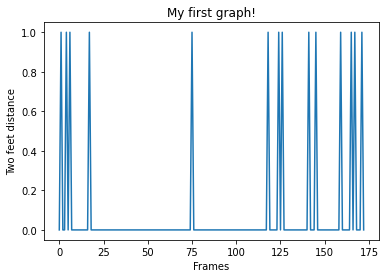

In [ ]:
# importing the required module
import matplotlib.pyplot as plt

# plotting the points
# plt.plot(feet_dist)
# plt.plot(angle_dist)
# plt.plot(height_reduction_list)
plt.plot(dhdt_list)


# naming the x axis
plt.xlabel('Frames')
# naming the y axis
plt.ylabel('Two feet distance')

# giving a title to my graph
plt.title('My first graph!')

# function to show the plot
plt.show()


# Hospital separation

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [ ]:
import xgboost as xgb

In [ ]:
print("Site, f1_mean, f1_std, acc_mean, acc_std")

for site in sorted_sites[1:6]:
  train = data[~np.array(list(map(lambda x: x.startswith(site), all_vid_names)))]
  test  = data[np.array(list(map(lambda x: x.startswith(site), all_vid_names)))]
  xtrain, ytrain = train.drop(['label'] , axis = 1)[rfacv_selected_cols], train['label']>0
  xtest, ytest = test.drop(['label'] , axis = 1), test['label']>0

  rf_scores_f1 = []
  rf_scores_acc = []
  for i in range(20):
    model = RandomForestClassifier(n_estimators=100)
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest[rfacv_selected_cols])
    f1 = f1_score(ytest, ypred, average='macro')
    acc = accuracy_score(ytest, ypred)
    rf_scores_f1.append(100*f1)
    rf_scores_acc.append(100*acc)

  print(site, np.mean(rf_scores_f1).round(2), '\t', np.std(rf_scores_f1).round(2), '\t', 
        np.mean(rf_scores_acc).round(2), '\t',  np.std(rf_scores_acc).round(2))

In [ ]:
## Hospital separation for regression

data2 = data[list(sorted_cols[:15])+['label']]

print("Site, MAE, std, CORR, std")

for site in sorted_sites[1:6]:
  train = data2[~np.array(list(map(lambda x: x.startswith(site), all_vid_names)))]
  test  = data2[np.array(list(map(lambda x: x.startswith(site), all_vid_names)))]
  xtrain, ytrain = train.drop(['label'] , axis = 1), train['label']
  xtest, ytest = test.drop(['label'] , axis = 1), test['label']

  total_mae = []
  total_corr = []
  for i in range(20):
    model = RandomForestRegressor(max_depth=10, random_state=0)
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)

    mae = np.mean(np.abs(ytest - ypred))
    corr = pearsonr(ytest, ypred)[0]
    total_mae.append(mae)
    total_corr.append(corr)

  print(site, np.mean(total_mae).round(4), '\t', np.std(total_mae).round(4),'\t', 
        np.mean(total_corr).round(4), '\t', np.std(total_corr).round(4))